# Introducing MyGrad
MyGrad is a simple, NumPy-centric autograd library. An autograd library enables you to automatically compute derivatives of mathematical functions. This library
is designed to serve primarily as an education tool for learning about gradient-based machine learning; it is easy to install, has a readable and easily customizable code
base, and provides a sleek interface that mimics NumPy. Furthermore, it leverages NumPy's vectorization
to achieve good performance despite the library's simplicity.

This is not meant to be a competitor to libraries like PyTorch (which `mygrad` most closely resembles) or
TensorFlow. Rather, it is meant to serve as a useful tool for students who are learning about training neural networks
using back propagation.

## Installing MyGrad
To install MyGrad clone [this repository](https://github.com/rsokl/MyGrad) and navigate to the MyGrad directory, then run:
```shell
python setup.py install
```

MyGrad requires `numpy`. It is highly recommended that you utilized `numpy` built with [MKL](https://en.wikipedia.org/wiki/Math_Kernel_Library)
 for access to optimized math routines.

## A Simple Application
Let's use `mygrad` to compute the derivative of
$f(x) = x^2$ evaluated at $x = 3$ (which is $\frac{df}{dx}\rvert_{x=3} = 2\times 3$).

`mygrad.Tensor` behaves nearly identically to NumPy's ndarray, in addition to having the machinery needed to
compute the analytic derivatives of functions. Suppose we want to compute this derivative at `x = 3`. We can create a
0-dimensional tensor (a scalar) for x and compute `f(x)`:

```python
>>> import mygrad as mg
>>> x = mg.Tensor(3.0)
>>> f = x ** 2
>>> f
Tensor(9.0)
```

Invoking `f.backward()` instructs `mygrad` to trace through the computational graph that produced `f` and compute the
derivatives of `f` with respect to all of its independent variables. Thus, executing `f.backward()` will compute $\frac{df}{dx} = 2x$ at $x=3$, and will store the resulting value in `x.grad`:

```python
>>> f.backward()  # triggers computation of `df/dx`
>>> x.grad  # df/dx = 2x = 6.0
array(6.0)
```

This is the absolute tip of the iceberg. `mygrad` can compute derivatives of multivariable composite
functions of tensor-valued variables!



## Some Bells and Whistles
`mygrad` supports all of NumPy's essential features, including:

 - [N-dimensional tensors](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/IntroducingTheNDarray.html) that can be reshaped and have their axes transposed
 - [vectorization](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html)
 - [broadcasting](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/Broadcasting.html)
 - [basic and advanced indexing](https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/BasicIndexing.html) (including all varieties of mixed indexing schemes) for both getting and setting items.
 - fully-fledged support for [einsum](https://rockt.github.io/2018/04/30/einsum) (including broadcasting and traces,
   which are not supported by PyTorch, TensorFlow, or HIPS-autograd)

 `mygrad.Tensor` plays nicely with NumPy-arrays, which behave as constants when they are used in computational graphs:

```python
>>> import numpy as np
>>> x = mg.Tensor([2.0, 2.0, 2.0])
>>> y = np.array([1.0, 2.0, 3.0])
>>> f = x ** y  # (2 ** 1, 2 ** 2, 2 ** 3)
>>> f.backward()
>>> x.grad
array([ 1.,  4., 12.])
```

`mygrad.nn` supplies essential functions for machine learning, including:
- N-dimensional convolutions (with striding, dilation, and padding)
- N-dimensional pooling
- A [gated recurrent unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) for sequence-learning (with input-level
  dropout and variational hidden-hidden dropout)

It leverages a nice [sliding window
view](https://github.com/rsokl/MyGrad/blob/a72ebc26acf5c254f59a562c8045698387763a41/mygrad/nnet/layers/utils.py#L6)
function, which produces convolution-style windowed views of arrays/tensors without making copies of them, to
intuitively (and quite efficiently) perform the neural network-style convolutions and pooling.

## Advanced Example
The following is an example of using `mygrad` to compute the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss) of classification scores and to "backpropagate" through (compute the gradient of) this loss. This example demonstrates some of mygrad's ability to perform backpropagation through broadcasted operations, basic indexing, advanced indexing, and in-place assignments.

```python
>>> from mygrad import Tensor
>>> import numpy as np
>>> class_scores = Tensor(10 * np.random.rand(100, 10))         # 100 samples, 10 possible classes for each
>>> class_labels = np.random.randint(low=0, high=10, size=100)  # correct label for each datum
>>> class_labels = (range(len(class_labels)), class_labels)
>>> correct_class_scores = class_scores[class_labels]

>>> Lij = class_scores - correct_class_scores[:, np.newaxis] + 1.  # 100x10 margins
>>> Lij[Lij <= 0] = 0      # scores within the hinge incur no loss
>>> Lij[class_labels] = 0  # the score corresponding to the correct label incurs no loss

>>> loss = Lij.sum() / class_scores.shape[0]  # compute mean hinge loss
>>> loss.backward()    # compute gradient of loss w.r.t all dependent tensors
>>> class_scores.grad  # d(loss)/d(class_scores)
array([[ 0.  ,  0.01,  0.  , -0.04,  0.  ,  0.  ,  0.01,  0.  ,  0.01, 0.01], ...])
```

## Computational Graph Visualization
MyGrad provides the capability to visually render diagrams of your computational graphs:


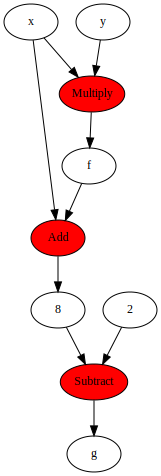

In [1]:
import mygrad as mg
from mygrad.computational_graph import build_graph
x = mg.Tensor(2)
y = mg.Tensor(3)
f = x * y
g = f + x - 2

build_graph(g, names=locals())


`mygrad` uses [Graphviz](http://www.graphviz.org) and a [Python interface for Graphviz](https://graphviz.readthedocs.io/en/stable/) to render the computational graphs built using tensors. These graphs can be rendered in Jupyter notebooks, allowing for quick checks of graph structure, or can be saved to file for later reference.

The dependencies can be installed with:

```shell
conda install graphviz
conda install python-graphviz
```

Big thanks to [Petar Griggs](https://github.com/petarmhg) for implementing these fantastic viz capabilities!